# Twitter Sarcasm anylysis of the DATASETS 

In [1]:
import torch 
import torch.nn as nn 
import pandas as pd 
import numpy as np 
import re
import seaborn as sns 

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train['class'].value_counts()

class
figurative    21238
irony         20894
sarcasm       20681
regular       18595
Name: count, dtype: int64

In [3]:
# X = Training data || y = testing data 
X_train = train['tweets'] 
X_labels = train['class'] 
y_train = test['tweets']
y_labels = test['class']

In [4]:
len(X_train) , len(y_train), len(X_labels), len(y_labels)

(81408, 8128, 81408, 8128)

In [5]:
from nltk.tokenize import word_tokenize  
from torch.utils.data import DataLoader, Dataset 
from nltk.corpus import stopwords 

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
device 

'cuda'

In [7]:
def preprocessor(text):
    if not isinstance(text, str):  # Convert non-string values to empty string
        text = str(text)
    
    text = re.sub(r'https?://\S+|www\.\S+', 'url', text)  # Remove URLs
    text = re.sub(r'\S+@\S+', 'email', text)  # Remove emails
    text = re.sub(r'@\S+', 'user', text)  # Remove mentions
    text = re.sub(r'\d+%', 'percentage', text)  # Remove percentages
    text = re.sub(r'\$\d+(\.\d+)?', 'money', text)  # Remove money amounts
    text = re.sub(r'\d+/\d+/\d+', 'date', text)  # Remove dates
    text = re.sub(r'\d+:\d+', 'time', text)  # Remove times
    text = re.sub(r'\d{3}-\d{3}-\d{4}', 'phone', text)  # Remove phone numbers
    text = re.sub(r'#(\S+)', lambda x: ' '.join(re.findall(r'[A-Z]?[a-z]+', x.group())), text)  # Process hashtags
    text = re.sub(r'\b(\w+?)\1{2,}\b', r'\1', text)  # Remove elongated words
    text = text.lower()  # Convert to lowercase

    words = text.split()
    stop_words = set(stopwords.words('english'))  # Load stopwords
    final_text = [word for word in words if word not in stop_words]  # Remove stopwords

    return ' '.join(final_text)

In [8]:
X_train = X_train.apply(preprocessor) 
y_train = y_train.apply(preprocessor)

In [9]:
X_train[0]

'aware dirty step get money staylight staywhite sarcastic moralneeded user url'

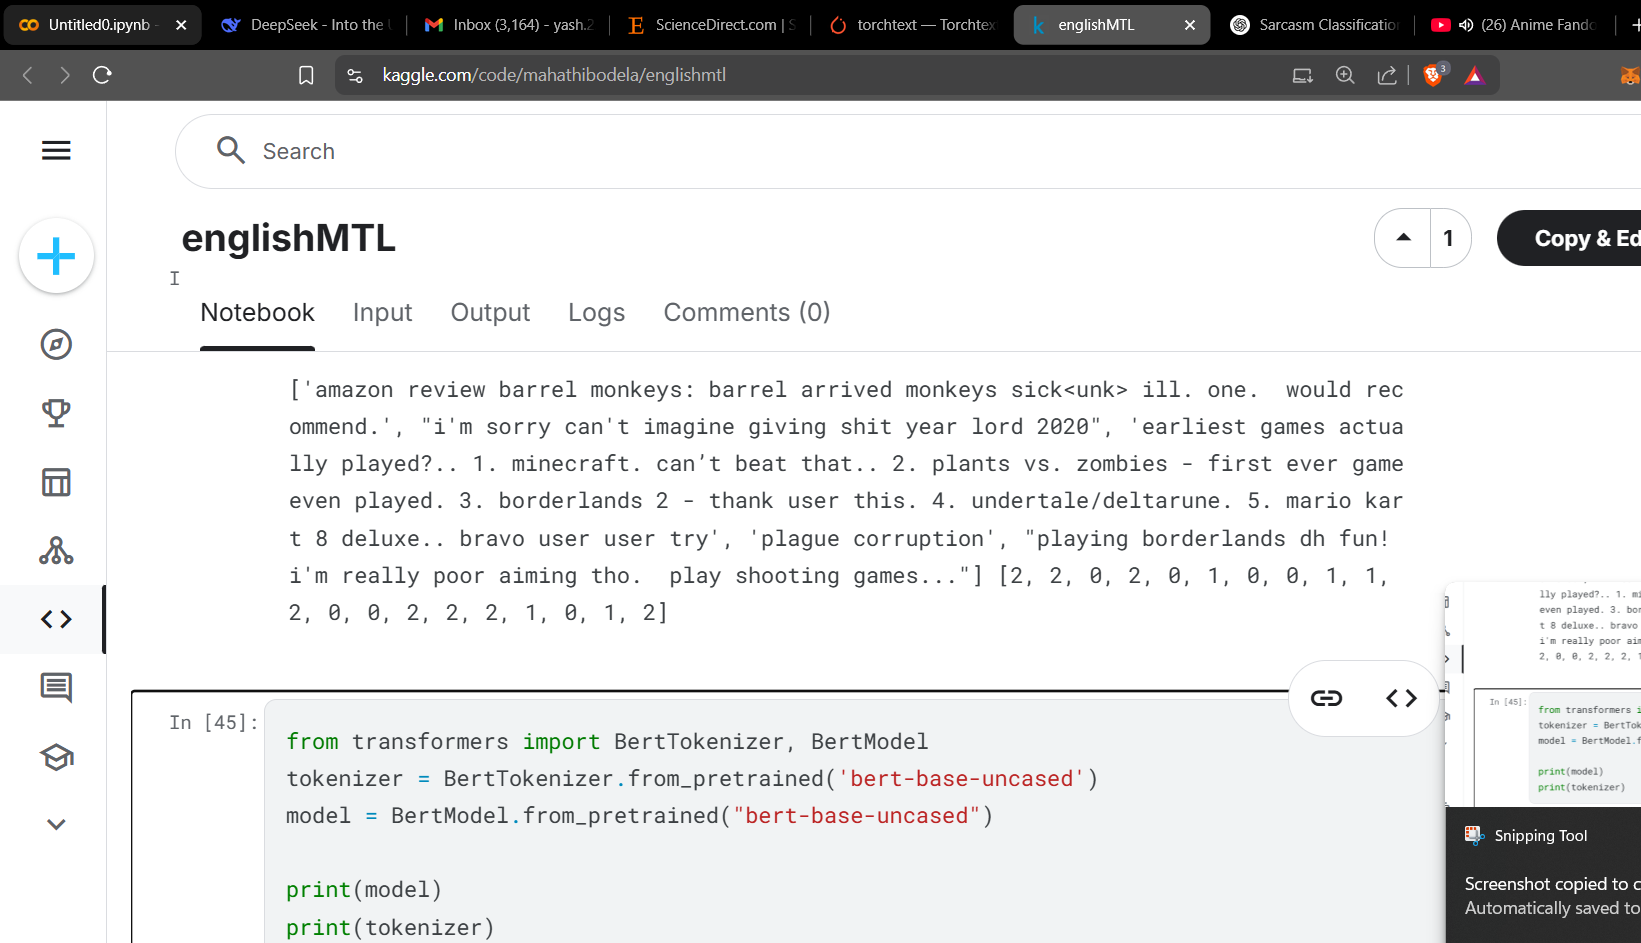

In [10]:
# Now training the Model based on the tokenization....
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained("bert-base-uncased")

model, tokenizer

c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(BertModel(
   (embeddings): BertEmbeddings(
     (word_embeddings): Embedding(30522, 768, padding_idx=0)
     (position_embeddings): Embedding(512, 768)
     (token_type_embeddings): Embedding(2, 768)
     (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
     (dropout): Dropout(p=0.1, inplace=False)
   )
   (encoder): BertEncoder(
     (layer): ModuleList(
       (0-11): 12 x BertLayer(
         (attention): BertAttention(
           (self): BertSdpaSelfAttention(
             (query): Linear(in_features=768, out_features=768, bias=True)
             (key): Linear(in_features=768, out_features=768, bias=True)
             (value): Linear(in_features=768, out_features=768, bias=True)
             (dropout): Dropout(p=0.1, inplace=False)
           )
           (output): BertSelfOutput(
             (dense): Linear(in_features=768, out_features=768, bias=True)
             (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
             (dropout): Dropou

In [11]:
# Tokenize the dataset

def tokenize_function(text): 
    if not isinstance(text, str):
        text = ""   
    return tokenizer(text, 
                     padding="max_length", 
                     truncation=True, 
                     max_length=128, 
                     return_tensors="pt")


# Apply to X_train and X_test
X_train_tokens = train['tweets'].apply(lambda x: tokenize_function(x))
y_train_tokens = test['tweets'].apply(lambda x: tokenize_function(x))

In [15]:
X_train_tokens[0]

{'input_ids': tensor([[  101,  2022,  5204,  6530,  3357,  2000,  2131,  2769,  1001,  2994,
          7138,  1001,  2994,  2860, 16584,  2063,  1001, 22473,  1001,  7191,
         24045,  5732,  1030,  1529, 16770,  1024,  1013,  1013,  1056,  1012,
          2522,  1013,  1051,  3501,  2575,  2497,  5149,  2595,  2509, 27767,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

In [12]:
print(train['class'].dtype)  # Check column type
print(train['class'].unique())  # See unique values in the column

object
['figurative' 'irony' 'regular' 'sarcasm']


In [13]:
label_mapping = {"sarcasm": 0, "irony": 1, "figurative":2, "regular": 3 } 


X_labels = X_labels.map(label_mapping).fillna(0).astype(int)
y_labels = y_labels.map(label_mapping).fillna(0).astype(int)

In [ ]:
from torch.utils.data import Dataset, DataLoader 

class SarcasmDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        tokens = self.texts[idx]
        return {
            'input_ids': tokens['input_ids'].squeeze(0),  
            'attention_mask': tokens['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Convert y_train to tensor
y_train_tensor = torch.tensor(X_labels.values, dtype=torch.long)

# Create dataset
train_dataset = SarcasmDataset(X_train_tokens, y_train_tensor)

# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [70]:
len(train_dataloader)

5088

In [64]:
print("Unique labels in X_labels:", X_labels.unique())
print("Unique labels in y_labels:", y_labels.unique())

Unique labels in X_labels: [2 1 3 0]
Unique labels in y_labels: [2 0 1 3]


In [67]:
for batch in train_dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)  # Labels should be (batch_size,)

    # ✅ Debugging Prints
    print("Input IDs shape:", input_ids.shape)  # Should be (batch_size, seq_len)
    print("Attention Mask shape:", attention_mask.shape)  # Should match input_ids
    print("Labels shape:", labels.shape)  # Should be (batch_size,)
    
    outputs = model(input_ids, attention_mask)

    print("Model Output shape:", outputs.shape)  # Should be (batch_size, 4)

    loss = loss_fn(outputs, labels)  # 🚨 CRASH HAPPENS HERE
    break  # Stop after first batch


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1304\2855861956.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(self.labels[idx], dtype=torch.long)


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [65]:
class BertForSarcasmClassification(nn.Module):
    def __init__(self, num_classes=4):
        super(BertForSarcasmClassification, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)  # Must match 4

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        return self.fc(self.dropout(pooled_output))

# ✅ Ensure the number of classes is correct
model = BertForSarcasmClassification(num_classes=4).to('cuda')

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [66]:
from transformers import AdamW
from torch.optim import Adam
import torch.nn.functional as F

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
loss_fn = nn.CrossEntropyLoss()

# Move model to GPU if available

c:\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [41]:
device

device(type='cuda')

In [44]:
print("Min label:", X_labels.min(), "Max label:", X_labels.max())

Min label: 0 Max label: 3


In [42]:
EPOCHS = 3
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    accuracy = correct / total
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Accuracy: {accuracy:.4f}")

C:\Users\ASUS\AppData\Local\Temp\ipykernel_1304\2855861956.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(self.labels[idx], dtype=torch.long)


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
